In [87]:
import os
import pandas as pd
DATAPATH = "../data/combine_mols"

In [88]:
#get the smiles discarding any that have less than 100 MW
lab_data = ["Cook's group csv.csv", "Dickman's group CSV.csv", "G25 alcohol containing Cmpds.csv", "Lab218 csv.csv"]
smiles= []
for d in lab_data:
    df = pd.read_csv(os.path.join(DATAPATH, "lab_available", d))
    print(df.shape)
    df = df[df["Molecular Weight"]>100]
    smi = df["SMILES"].tolist()
    print(len(smi))
    smiles += smi

(16, 15)
9
(74, 15)
60
(111, 15)
90
(53, 15)
34


In [89]:
#make sure all molecules contain an alcohol group
from rdkit import Chem

def has_alcohol_group(molecule):
    mol = Chem.MolFromSmiles(molecule)
    if mol is not None:
        # Check if the molecule contains an alcohol group
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 8 and atom.GetTotalNumHs() == 1:
                return True
    return False

def filter_molecules_with_alcohol(molecule_list):
    filtered_molecules = [mol for mol in molecule_list if has_alcohol_group(mol)]
    return filtered_molecules

filtered_smiles = filter_molecules_with_alcohol(smiles)
print(len(filtered_smiles))

193


In [90]:
#for simplicity we will only combine molecules that have one alcohol group, not more
def count_alcohol_groups(molecule):
    mol = Chem.MolFromSmiles(molecule)
    if mol is not None:
        # Count the number of alcohol groups in the molecule
        alcohol_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 8 and atom.GetTotalNumHs() == 1)
        return alcohol_count
    return 0

def filter_molecules_with_one_alcohol(molecule_list):
    filtered_molecules = [mol for mol in molecule_list if count_alcohol_groups(mol) == 1]
    return filtered_molecules

filtered_smiles = filter_molecules_with_one_alcohol(filtered_smiles)
print(len(filtered_smiles))

137


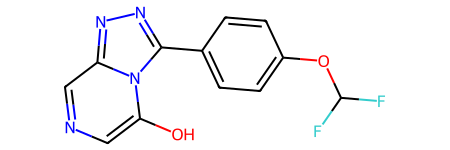

In [91]:
scaffold = "OC1=CN=CC2=NN=C(N12)C1=CC=C(OC(F)F)C=C1"
mol = Chem.MolFromSmiles(scaffold)
mol

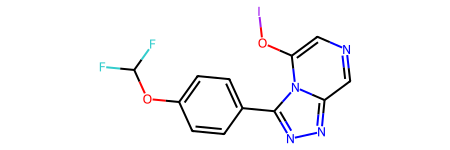

In [92]:
scaffold_dummy = "FC(F)OC1=CC=C(C=C1)C1=NN=C2C=NC=C(OI)N12" #contains an extra I for the join
mol = Chem.MolFromSmiles(scaffold_dummy)
mol

In [93]:
# Replace OH group by I in the fragments to allow the joining

def replace_oh_with_i(molecule_list):
    modified_molecules = []
    for smi in molecule_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            # Find the atom indices of the -OH group
            oh_atom_indices = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() == 'O' and atom.GetTotalNumHs() == 1]

            # Replace -OH with I
            for oh_index in oh_atom_indices:
                mol.GetAtomWithIdx(oh_index).SetAtomicNum(53)  # 53 is the atomic number for iodine

            # Convert the modified molecule to SMILES notation
            modified_smi = Chem.MolToSmiles(mol)
            modified_molecules.append(modified_smi)

    return modified_molecules

dummy_frags = replace_oh_with_i(filtered_smiles)

In [94]:
from CombineMols.CombineMols import CombineMols

combined_smiles = []

for dummy_frag in dummy_frags:
    mol1 = Chem.MolFromSmiles(scaffold_dummy)
    mol2 = Chem.MolFromSmiles(dummy_frag)
    m = CombineMols(mol1, mol2, "I")
    smi = Chem.MolToSmiles(m[0])
    combined_smiles += [smi]

print(len(combined_smiles))

In [98]:
#save the file to manually check if the joining is correct before running predictions
df = pd.DataFrame({"fragment": filtered_smiles, "dummy": dummy_frags, "smiles":combined_smiles})
df.to_csv(os.path.join(DATAPATH, "combined_mols.csv"), index=False)